In [1]:
from pathlib import Path
import sys
sys.path.append('../')
from pma_open import *
from skimage.util.shape import view_as_blocks
from scipy.ndimage import gaussian_filter
from skimage.feature import peak_local_max

#My image
file_path = '../pma files/hel1.pma'
image_path = "hel1_Avg_Frame/hel1_Avg_Frame.png"
image = io.imread(image_path, as_gray=True)

#Image on dropbox
hel1_ave_path = '../pma files/hel1_ave_LF_Circ.tif'
hel1_ave_image = io.imread(hel1_ave_path)

#Testing avg_frame_arr function
avg_frame_data = avg_frame_arr(file_path)

Image Size: 512 x 512
Sucessfully generated average frame


## Creation of CH1 array + CH1 image + CH1 image path

Average CH1 Frame Data- shape: (512, 256)
Average CH1 Frame Data- Type: <class 'numpy.ndarray'>
Average CH1 Frame Data- dType: uint8


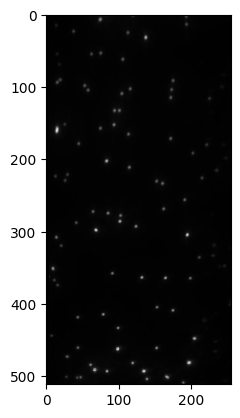

In [2]:
#Chanel 1 image
avg_frame_data_CH1 = avg_frame_data[:,:256]

#CH1 image path
CH1_img_path = "hel1_Avg_Frame/hel1_Avg_Frame_CH1.png"
# image_CH1 = Image.fromarray(avg_frame_data_CH1)
# image_CH1.save(CH1_img_path)

#CH1 image name: image_CH1
image_CH1 = io.imread(CH1_img_path, as_gray=True)

print(f"Average CH1 Frame Data- shape: {avg_frame_data_CH1.shape}")
print(f"Average CH1 Frame Data- Type: {type(avg_frame_data_CH1)}")
print(f"Average CH1 Frame Data- dType: {avg_frame_data_CH1.dtype}")

#Display Average frame using matplotlib
image = plt.imshow(avg_frame_data_CH1, cmap="grey");

In [3]:
#SAME find_peaks_scipy_IDL function as in imv_avg.ipynb file
def find_peaks_scipy_IDL(image_path, sigma=2, block_size=16, std=10, scaler_percent=35):

    # Load image (assumes grayscale uint8 image)
    image = io.imread(image_path, as_gray=True).astype(np.uint8)
    height, width = image.shape

    # Smooth the image
    image_1 = gaussian_filter(image, sigma, mode='nearest')
    # Compute intensity threshold based on scaler_percent
    min_intensity = np.min(image_1)
    max_intensity = np.max(image_1)
    threshold = min_intensity + (scaler_percent / 100.0) * (max_intensity - min_intensity)

    # Compute a low-resolution background estimation
    background = np.zeros((height, width), dtype=np.float32)
    
    for i in range(8, height, block_size):
        for j in range(8, width, block_size):
            background[(i-8)//block_size, (j-8)//block_size] = np.min(image_1[i-8:i+8, j-8:j+8])
    
    # Subtract background
    background = np.clip(background.astype(np.uint8) - 10, 0, 255)
    image_1 = image - background
    
    # Apply intensity threshold
    image_2 = image_1.copy()
    med = np.median(image_1)
    # std = 10  # Manually defined
    image_2[image_2 < (med + std)] = 0
    
    # Detect peaks using peak_local_max
    peak_coords = peak_local_max(image_2, min_distance=int(sigma), threshold_abs=threshold)
    
    return peak_coords


In [4]:
peaks_coords_IDL_CH1 = find_peaks_scipy_IDL(CH1_img_path)
print(f"First 10 peak coordinates:\n {peaks_coords_IDL_CH1[:10]}")
print(f"Peaks data type: {type(peaks_coords_IDL_CH1)}")
print(f"Number of peaks: {len(peaks_coords_IDL_CH1)}")

First 10 peak coordinates:
 [[493 135]
 [464  99]
 [160  15]
 [305 195]
 [483 197]
 [493  66]
 [298  69]
 [494  84]
 [449 205]
 [ 32 138]]
Peaks data type: <class 'numpy.ndarray'>
Number of peaks: 83


/var/folders/r0/qp6_p2111v1dzb0fg2bbfqsr0000gn/T/ipykernel_5183/370416374.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))


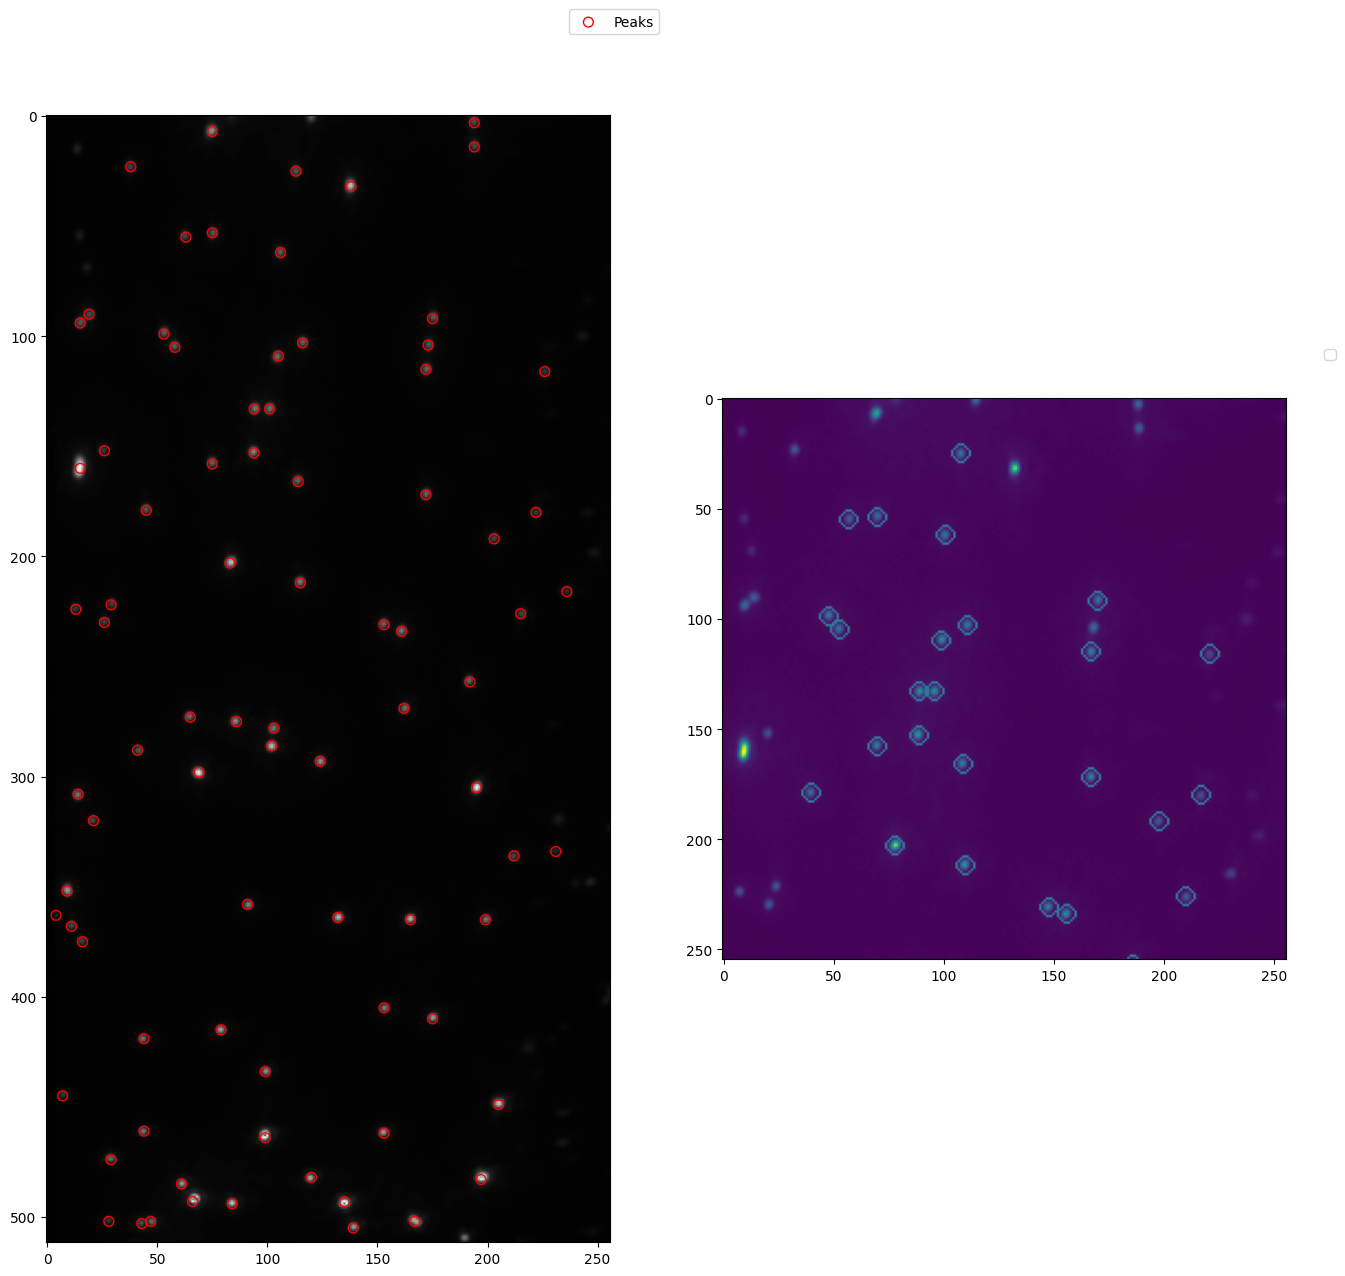

In [5]:
#Displaying CH1 image alongside IDL CH1 image from dropbox
f, axes = plt.subplots(1, 2, figsize=(16, 16))

axes[0].imshow(image_CH1, cmap="grey")
axes[0].scatter(peaks_coords_IDL_CH1[:, 1], peaks_coords_IDL_CH1[:, 0], s=50, facecolors='none', edgecolors='r', label='Peaks')
axes[0].legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

#display ../pma files/hel1_ave_LF_Circ.tif next to plt.imshow(image) side by side
axes[1].imshow(hel1_ave_image[:, :256])
axes[1].legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.show()

## Exclude 10 x 10 pixel boarder

In [6]:
#Same Good Peaks as in img_avg.ipynb file
def good_peak_finder(image_path, sigma=2, block_size=16, std=10, scaler_percent=35, boarder=10, max_peak_radius=2):
    peak_coors = find_peaks_scipy_IDL(image_path, sigma, block_size, std, scaler_percent)
    good_peaks = []
    bad_peaks = []
    height, width = io.imread(image_path).shape
    for peak in peak_coors:
        # add condition that peak cannot be larger than 4x4
        if peak[0] < boarder or peak[0] > height - boarder or peak[1] < boarder or peak[1] > width - boarder:
            bad_peaks.append(peak)
        else:
            good_peaks.append(peak)
    good_peaks = np.array(good_peaks)
    bad_peaks = np.array(bad_peaks)
    return good_peaks, bad_peaks


In [7]:
print(f"How many good peaks: {len(good_peak_finder(CH1_img_path)[0])}")
print(f"First Good Peak: {good_peak_finder(CH1_img_path)[0][0]}")

How many good peaks: 76
First Good Peak: [493 135]


In [22]:
# #how to find the size of the bright spot for each peak in good_peaks
# std=10
# block_size=16
# sigma =2
# scaler_percent=80
# max_rad=3

# height, width = image_CH1.shape
# good_peaks, bad_peaks = good_peak_finder(CH1_img_path)
# image_CH1_1 = image_CH1.copy()
# min_intensity = np.min(image_CH1_1)
# max_intensity = np.max(image_CH1_1)
# threshold = min_intensity + (scaler_percent / 100.0) * (max_intensity - min_intensity)
    
# background = np.zeros((height, width), dtype=np.float32)

# for i in range(8, height, block_size):
#     for j in range(8, width, block_size):
#         background[(i-8)//block_size, (j-8)//block_size] = np.min(image_CH1_1[i-8:i+8, j-8:j+8])
    
# # Subtract background
# background = np.clip(background.astype(np.uint8) - 10, 0, 255)
# image_CH1_1 = image_CH1 - background
    
# image_CH1_2 = image_CH1_1.copy()
# med = np.median(image_CH1_1)

# # Apply threshold
# image_CH1_2[image_CH1_2 < (med + std)] = 0
# correct_size_peaks = []
# large_peaks = []

# for peak in good_peaks:
#     x, y = peak
#     # Extract the peak region, if pixels outside of 5x5 region are non-zero, then append peak to large_peaks
#     if np.any(image_CH1[x - max_rad:x + max_rad + 1, y - max_rad:y + max_rad + 1] > 0):
#         large_peaks.append(peak)
#     else:
#         correct_size_peaks.append(peak)

# correct_size_peaks = np.array(correct_size_peaks)
# large_peaks = np.array(large_peaks)

In [ ]:
# Calculate background a remove the background from the image to find peaks


In [21]:
print(image_CH1_2[484:504, 126:144])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  49   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  59  90 107  94  66  49   0   0   0   0   0]
 [  0   0   0   0   0   0  49 103 181 223 186 110  58   0   0   0   0   0]
 [  0   0   0   0   0   0  58 131 191 121 212 116  55   0   0   0   0   0]
 [  0   0   0   0   0   0  50  95 153 173 133  76   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  64  70  59   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0

In [10]:
print(f"Correct size peaks array:{correct_size_peaks}")
print(f"Correct size peaks array shape:{correct_size_peaks.shape}")
# print(f"Correct size peaks array:{large_peaks}")
# print(f"Correct size peaks array shape:{large_peaks.shape}")


Correct size peaks array:[]
Correct size peaks array shape:(0,)


In [11]:
# def small_peak_filter(image_path, sigma=2, block_size=16, std=10, scaler_percent=35, boarder=10, max_peak_radius=2):
#     # function exludes peaks that are larger than 5x5 pixels
#     good_peaks, bad_peaks = good_peak_finder(image_path, sigma, block_size, std, scaler_percent, boarder, max_peak_radius)
#     small_peaks = []
#     for peak in good_peaks:
#         if peak[0] - max_peak_radius < 0 or peak[0] + max_peak_radius > height or peak[1] - max_peak_radius < 0 or peak[1] + max_peak_radius > width:
#             small_peaks.append(peak)
#         else:
#             large_peaks.append(peak)


/var/folders/r0/qp6_p2111v1dzb0fg2bbfqsr0000gn/T/ipykernel_5183/2996240581.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))


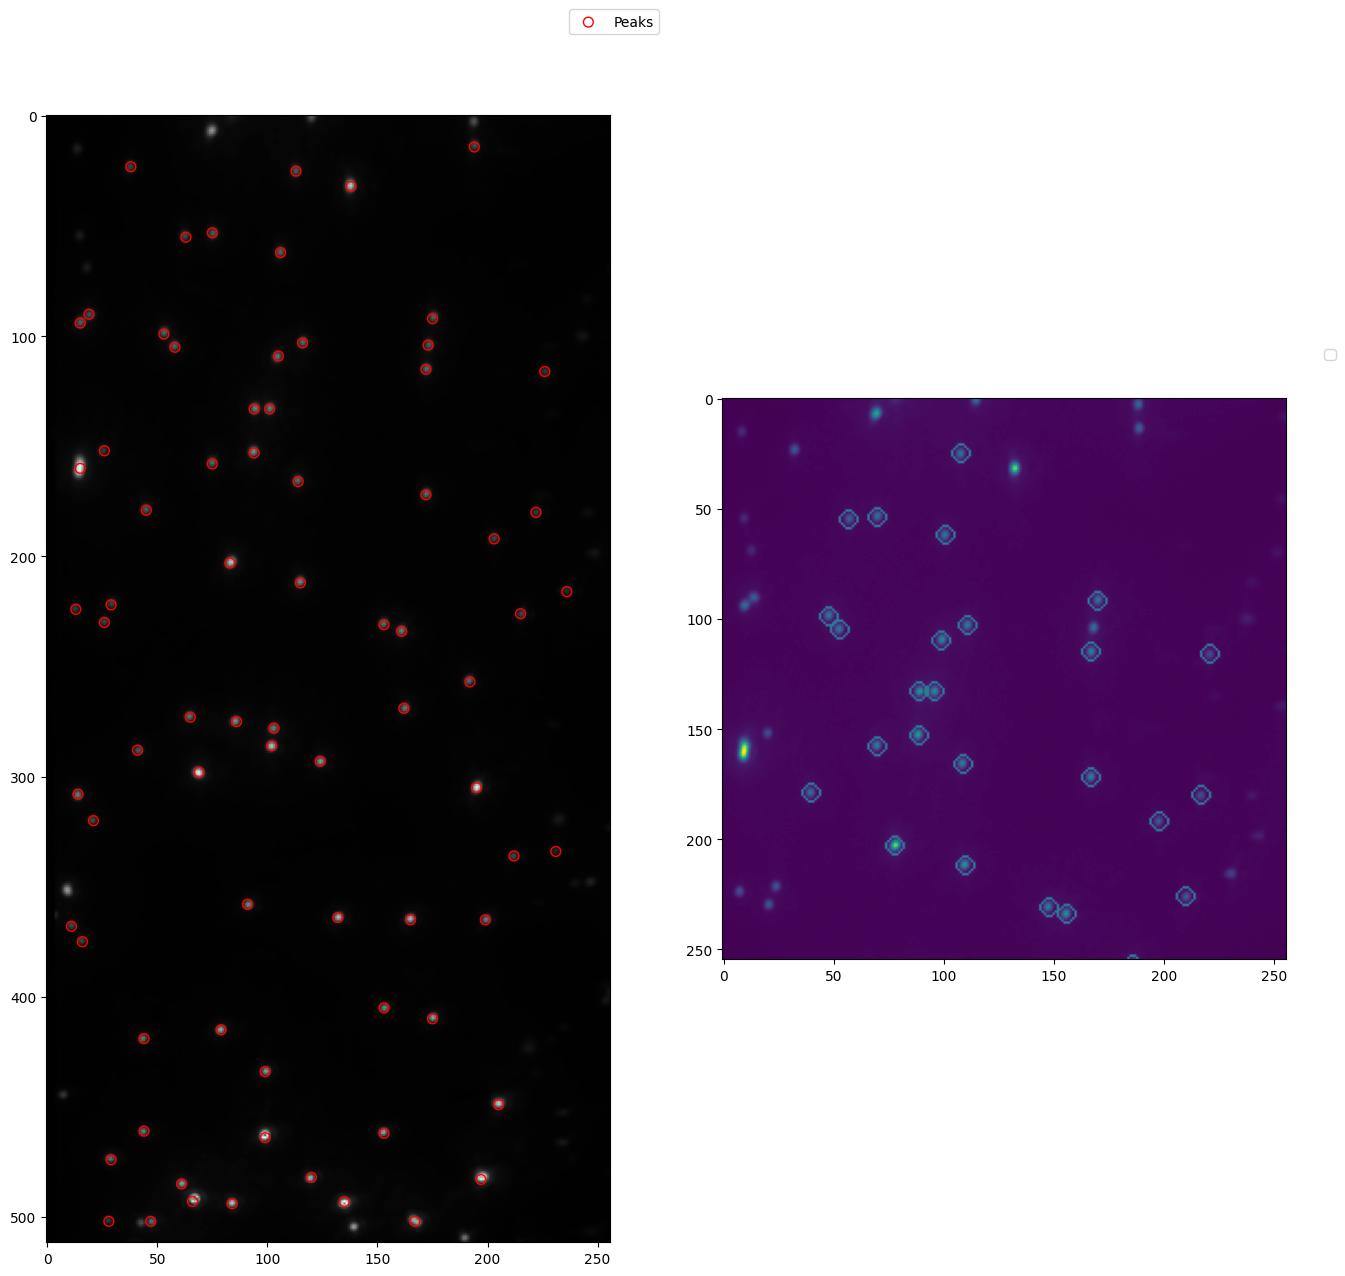

In [12]:
#Testing
good_peaks, bad_peaks = good_peak_finder(CH1_img_path)

f, axes = plt.subplots(1, 2, figsize=(16, 16))

axes[0].imshow(image_CH1, cmap="gray")
axes[0].scatter(good_peaks[:, 1], good_peaks[:, 0], s=50, facecolors='none', edgecolors='r', label='Peaks')
axes[0].legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

#display ../pma files/hel1_ave_LF_Circ.tif next to plt.imshow(image) side by side
axes[1].imshow(hel1_ave_image[:, :256])
axes[1].legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

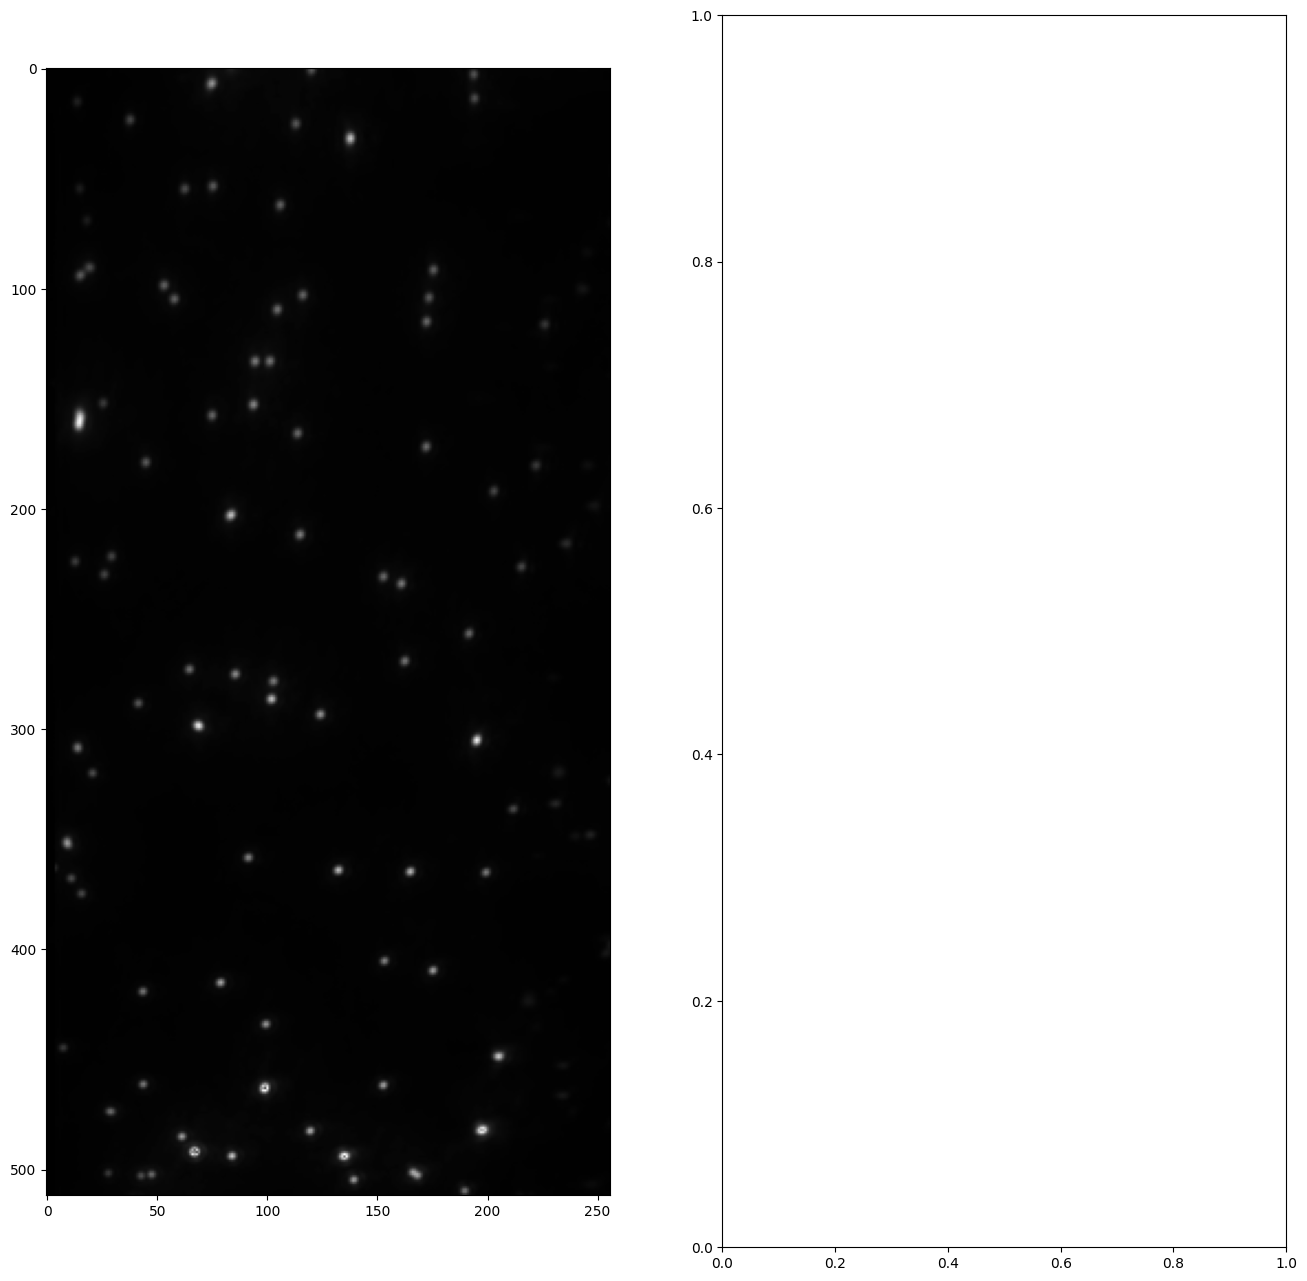

In [13]:
#Testing correct_size_peaks
f, axes = plt.subplots(1, 2, figsize=(16, 16))

axes[0].imshow(image_CH1, cmap="gray")
axes[0].scatter(correct_size_peaks[:, 1], correct_size_peaks[:, 0], s=50, facecolors='none', edgecolors='r', label='Peaks')
axes[0].legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

#display ../pma files/hel1_ave_LF_Circ.tif next to plt.imshow(image) side by side
axes[1].imshow(hel1_ave_image[:, :256])
axes[1].legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.show()